# Food Demand Forecasting

Your client is a meal delivery company which operates in multiple cities. They have various fulfillment centers in these cities for dispatching meal orders to their customers. The client wants you to help these centers with demand forecasting for upcoming weeks so that these centers will plan the stock of raw materials accordingly.

The replenishment of majority of raw materials is done on weekly basis and since the raw material is perishable, the procurement planning is of utmost importance. Secondly, staffing of the centers is also one area wherein accurate demand forecasts are really helpful. Given the following information, the task is to predict the demand for the next 10 weeks (Weeks: 146-155) for the center-meal combinations in the test set:  

- Historical data of demand for a product-center combination (Weeks: 1 to 145)
- Product(Meal) features such as category, sub-category, current price and discount
- Information for fulfillment center like center area, city information etc.

## Data Dictionary

#### Weekly Demand data (train.csv): Contains the historical demand data for all centers, test.csv contains all the following features except the target variable:
- id: Unique ID
- week: Week No
- center_id: Unique ID for fulfillment center
- meal_id: Unique ID for Meal
- checkout_price: Final price including discount, taxes & delivery charges
- base_price: Base price of the meal
- emailer_for_promotion: Emailer sent for promotion of meal
- homepage_featured: Meal featured at homepage
- num_orders: (Target) Orders Count

#### fulfilment_center_info.csv: Contains information for each fulfilment center
- center_id: Unique ID for fulfillment center
- city_code: Unique code for city
- region_code: Unique code for region
- center_type: Anonymized center type
- op_area: Area of operation (in km^2)

#### meal_info.csv: Contains information for each meal being served
- meal_id: Unique ID for the meal
- category: Type of meal (beverages/snacks/soups….)
- cuisine: Meal cuisine (Indian/Italian/…)

## Evaluation Metric
The evaluation metric for this competition is 100*RMSLE where RMSLE is Root of Mean Squared Logarithmic Error across all entries in the test set.

# EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
fulfilment_center_info = pd.read_csv('./data/train/fulfilment_center_info.csv')
meal_info = pd.read_csv('./data/train/meal_info.csv')
train = pd.read_csv('./data/train/train.csv')

In [3]:
print(f"fulfilment_center_info shape: {fulfilment_center_info.shape}")
fulfilment_center_info.head()

fulfilment_center_info shape: (77, 5)


,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [4]:
print(f"meal_info shape: {meal_info.shape}")
meal_info.head()

meal_info shape: (51, 3)


,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [5]:
print(f"train shape: {train.shape}")
train.head()

train shape: (456548, 9)


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [6]:
train_df = pd.merge(train, meal_info, on='meal_id', how='left')
train_df = pd.merge(train_df, fulfilment_center_info, on='center_id', how='left')

In [7]:
print(f"train df shape: {train_df.shape}")
train_df

train df shape: (456548, 15)


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0
1,1466964,1,55,1993,136.83,135.83,0,0,270,Beverages,Thai,647,56,TYPE_C,2.0
2,1346989,1,55,2539,134.86,135.86,0,0,189,Beverages,Thai,647,56,TYPE_C,2.0
3,1338232,1,55,2139,339.50,437.53,0,0,54,Beverages,Indian,647,56,TYPE_C,2.0
4,1448490,1,55,2631,243.50,242.50,0,0,40,Beverages,Indian,647,56,TYPE_C,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456543,1271326,145,61,1543,484.09,484.09,0,0,68,Desert,Indian,473,77,TYPE_A,4.5
456544,1062036,145,61,2304,482.09,482.09,0,0,42,Desert,Indian,473,77,TYPE_A,4.5
456545,1110849,145,61,2664,237.68,321.07,0,0,501,Salad,Italian,473,77,TYPE_A,4.5
456546,1147725,145,61,2569,243.50,313.34,0,0,729,Salad,Italian,473,77,TYPE_A,4.5


In [8]:
train_df.describe()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,op_area
count,4.565480e+05,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.00000,456548.000000,456548.000000,456548.000000,456548.000000
mean,1.250096e+06,74.768771,82.105796,2024.337458,332.238933,354.156627,0.081152,0.10920,261.872760,601.553399,56.614566,4.083590
std,1.443548e+05,41.524956,45.975046,547.420920,152.939723,160.715914,0.273069,0.31189,395.922798,66.195914,17.641306,1.091686
min,1.000000e+06,1.000000,10.000000,1062.000000,2.970000,55.350000,0.000000,0.00000,13.000000,456.000000,23.000000,0.900000
25%,1.124999e+06,39.000000,43.000000,1558.000000,228.950000,243.500000,0.000000,0.00000,54.000000,553.000000,34.000000,3.600000
50%,1.250184e+06,76.000000,76.000000,1993.000000,296.820000,310.460000,0.000000,0.00000,136.000000,596.000000,56.000000,4.000000
75%,1.375140e+06,111.000000,110.000000,2539.000000,445.230000,458.870000,0.000000,0.00000,324.000000,651.000000,77.000000,4.500000
max,1.499999e+06,145.000000,186.000000,2956.000000,866.270000,866.270000,1.000000,1.00000,24299.000000,713.000000,93.000000,7.000000


## Null values

In [9]:
train_df.isna().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
category                 0
cuisine                  0
city_code                0
region_code              0
center_type              0
op_area                  0
dtype: int64

## Categorical / Numeric features

In [10]:
categorical_vars = [col for col in train_df.columns if train_df[col].dtype == 'object' or train_df[col].nunique()<90]
categorical_vars

['center_id',
 'meal_id',
 'emailer_for_promotion',
 'homepage_featured',
 'category',
 'cuisine',
 'city_code',
 'region_code',
 'center_type',
 'op_area']

In [11]:
train_df[categorical_vars].head()

,center_id,meal_id,emailer_for_promotion,homepage_featured,category,cuisine,city_code,region_code,center_type,op_area
0,55,1885,0,0,Beverages,Thai,647,56,TYPE_C,2.0
1,55,1993,0,0,Beverages,Thai,647,56,TYPE_C,2.0
2,55,2539,0,0,Beverages,Thai,647,56,TYPE_C,2.0
3,55,2139,0,0,Beverages,Indian,647,56,TYPE_C,2.0
4,55,2631,0,0,Beverages,Indian,647,56,TYPE_C,2.0


In [12]:
numeric_vars = [col for col in train_df.columns if train_df[col].dtype != 'object' and train_df[col].nunique()>90 and "id" not in col]
numeric_vars

['week', 'checkout_price', 'base_price', 'num_orders']

In [13]:
train_df[numeric_vars].head()

,week,checkout_price,base_price,num_orders
0,1,136.83,152.29,177
1,1,136.83,135.83,270
2,1,134.86,135.86,189
3,1,339.50,437.53,54
4,1,243.50,242.50,40


In [14]:
id_vars = [col for col in train_df.columns if "id" in col]
id_vars

['id', 'center_id', 'meal_id']

In [15]:
train_df[id_vars].head()

,id,center_id,meal_id
0,1379560,55,1885
1,1466964,55,1993
2,1346989,55,2539
3,1338232,55,2139
4,1448490,55,2631


### Categorical features

Amount of unique values for center_id: 77


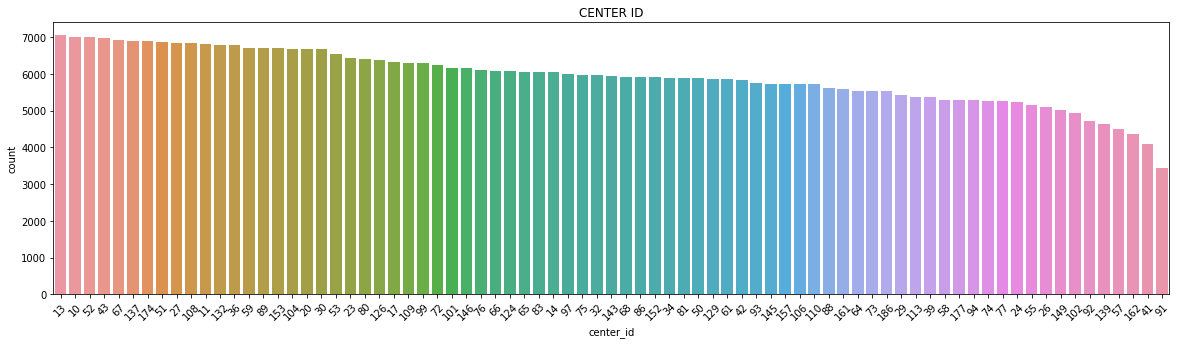




Amount of unique values for meal_id: 51


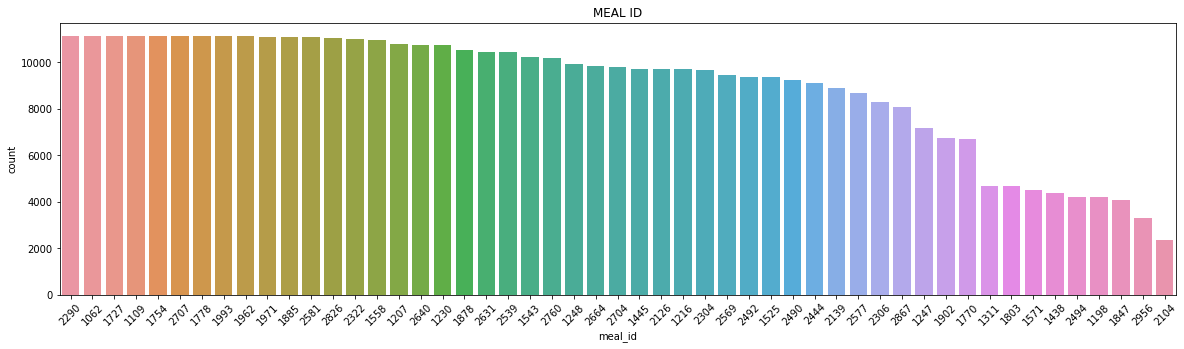




Amount of unique values for emailer_for_promotion: 2


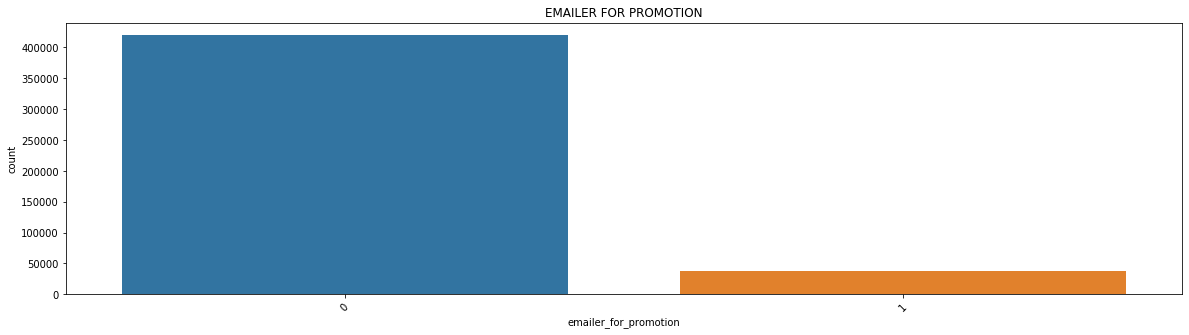




Amount of unique values for homepage_featured: 2


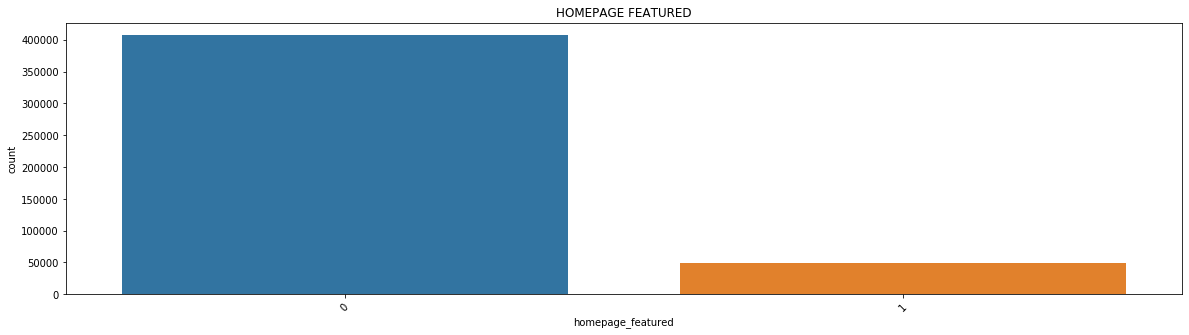




Amount of unique values for category: 14


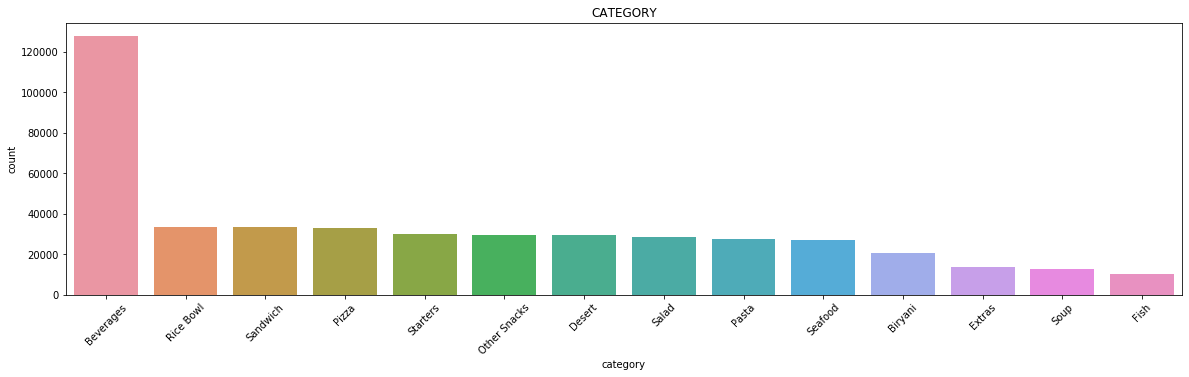




Amount of unique values for cuisine: 4


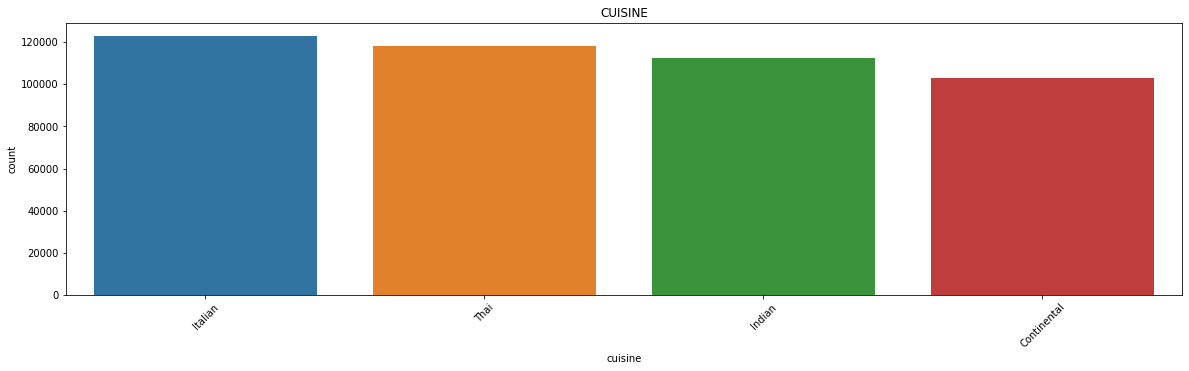




Amount of unique values for city_code: 51


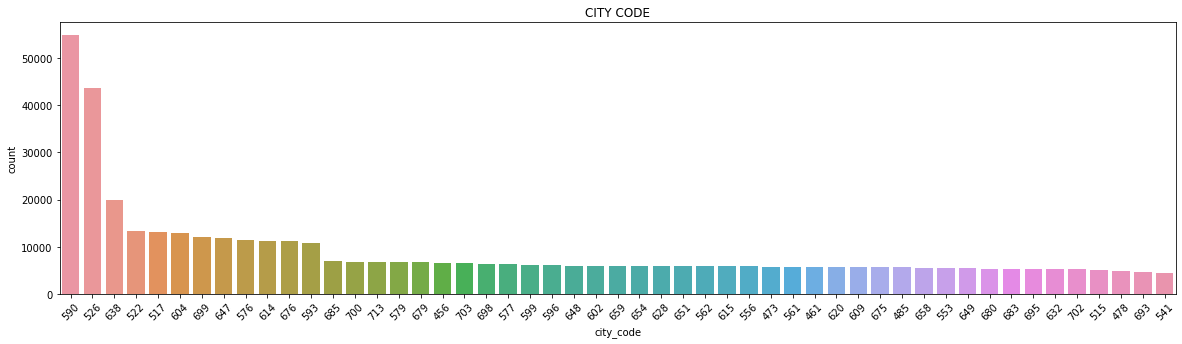




Amount of unique values for region_code: 8


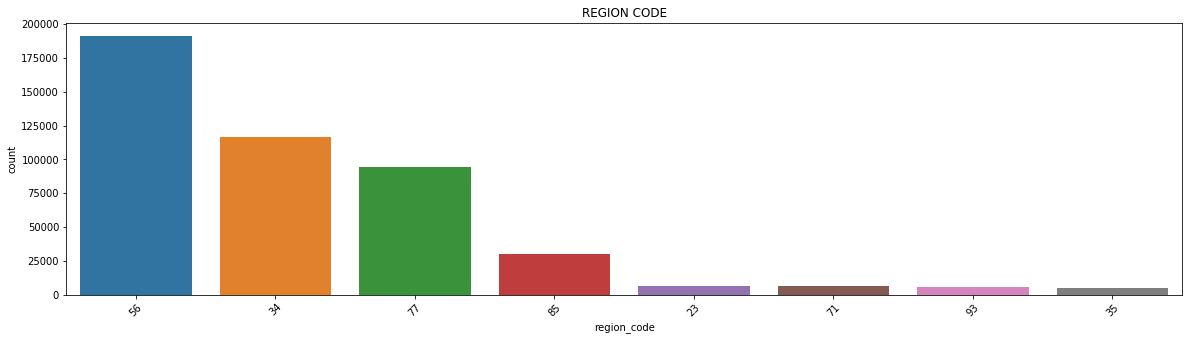




Amount of unique values for center_type: 3


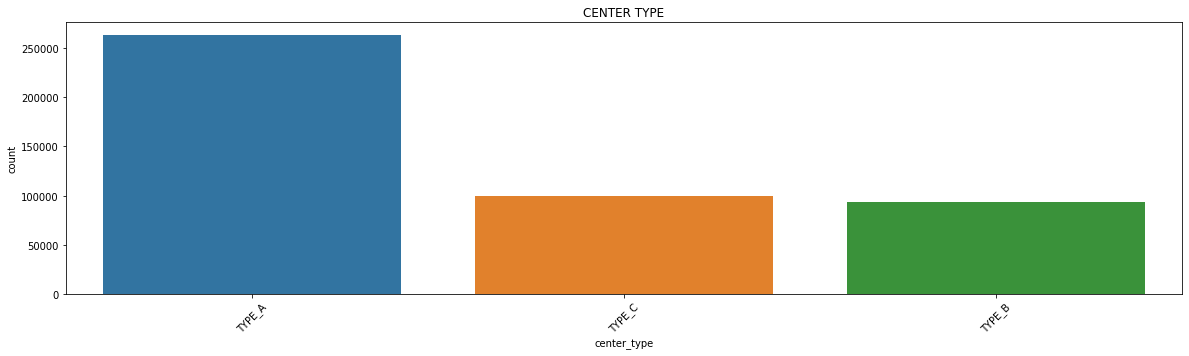




Amount of unique values for op_area: 30


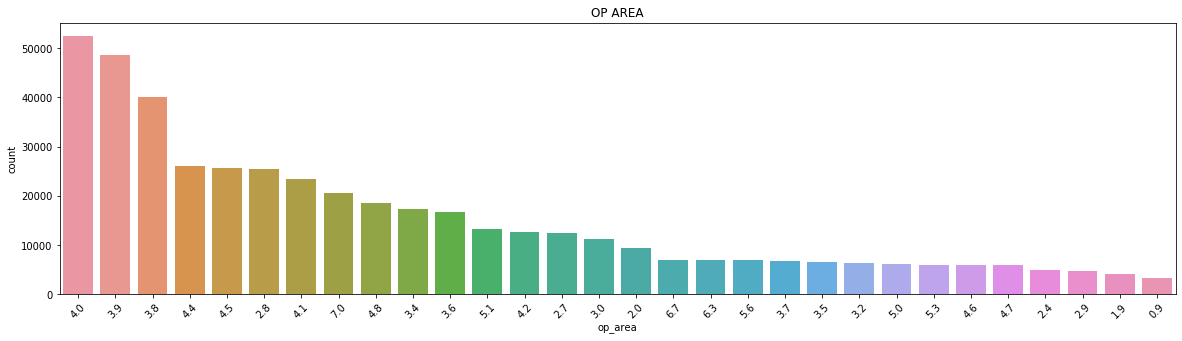

In [16]:
for cat in categorical_vars:
    print(f"Amount of unique values for {cat}: {train_df[cat].nunique()}")
    plt.figure(figsize=(20,5))
    sns.countplot(x=train_df[cat], order = train_df[cat].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(cat.replace('_',' ').upper())
    plt.show()
    print('\n\n')

Amount of unique values for center_id: 77


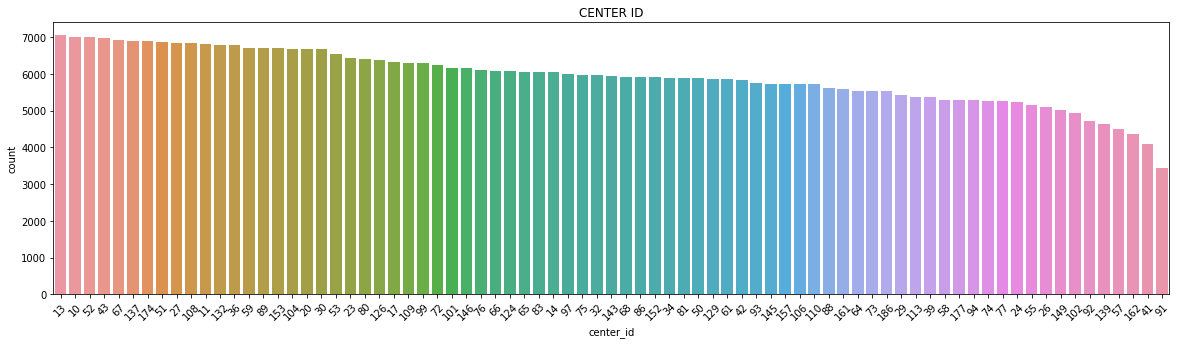




Amount of unique values for meal_id: 51


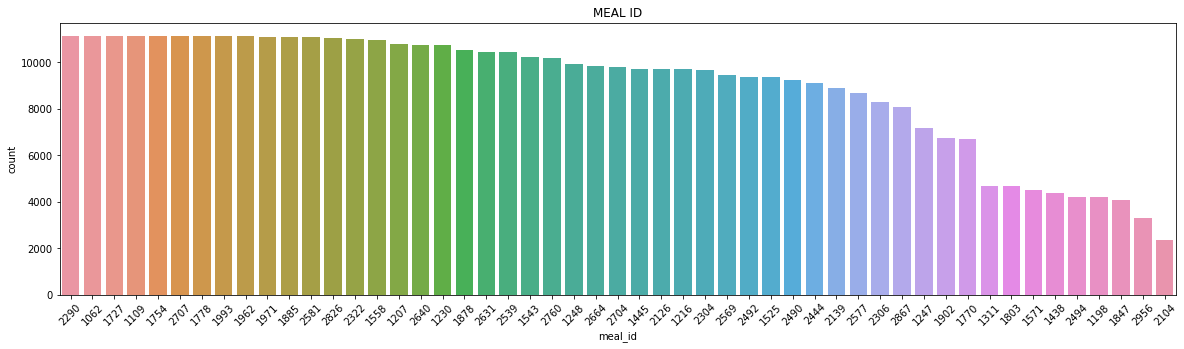

In [17]:
graph_ids = id_vars.copy()
graph_ids.remove('id')
for cat in graph_ids:
    print(f"Amount of unique values for {cat}: {train_df[cat].nunique()}")
    plt.figure(figsize=(20,5))
    sns.countplot(x=train_df[cat], order = train_df[cat].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(cat.replace('_',' ').upper())
    plt.show()
    print('\n\n')

## Target

In [18]:
target_name = 'num_orders'
train_df[target_name].describe()

count    456548.000000
mean        261.872760
std         395.922798
min          13.000000
25%          54.000000
50%         136.000000
75%         324.000000
max       24299.000000
Name: num_orders, dtype: float64

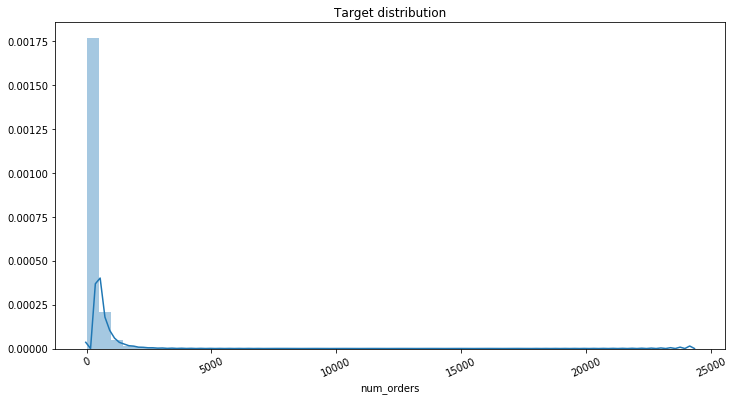

In [19]:
plt.figure(figsize=(12,6))
sns.distplot(train_df[target_name], bins=50)
plt.xticks(rotation=25)
plt.title('Target distribution')
plt.show()

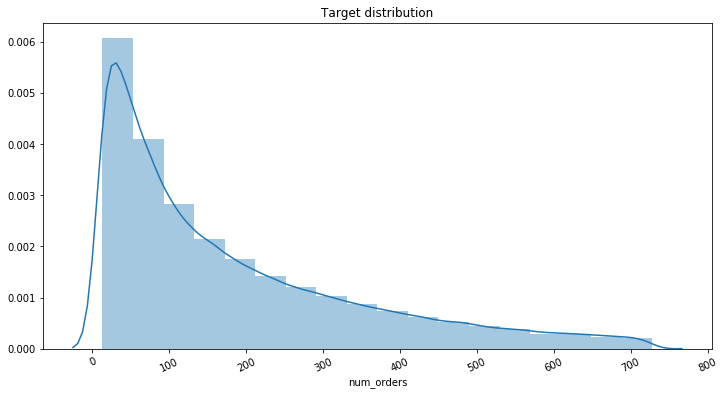

In [20]:
q1 = train_df[target_name].quantile(.25)
q2 = train_df[target_name].quantile(.75)
iqr = q2 - q1

iqr_target = train_df[ (train_df[target_name] > (q1 - 1.5*iqr)) & (train_df[target_name] < (q2 + 1.5*iqr)) ][target_name]

plt.figure(figsize=(12,6))
sns.distplot(iqr_target, bins=18)
plt.xticks(rotation=25)
plt.title('Target distribution')
plt.show()

## Correlations against target

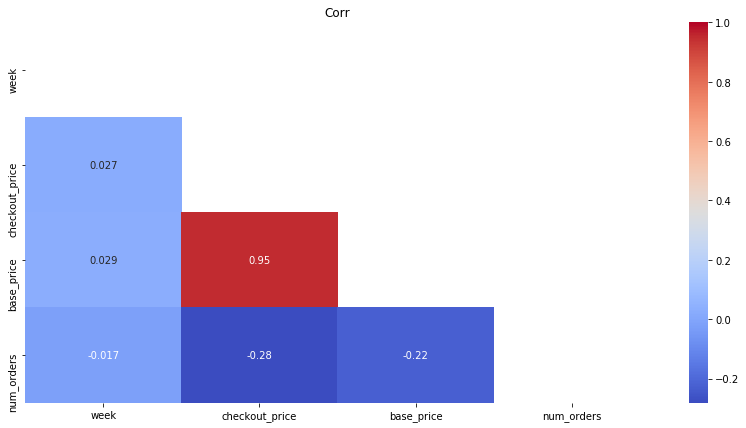

In [21]:
corr_vars = numeric_vars.copy()
mask = np.zeros_like(train_df[corr_vars].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(14,7))
sns.heatmap(train_df[corr_vars].corr(), annot = True, cmap='coolwarm',mask = mask)
plt.title('Corr')
plt.show()

Amount of unique values for center_id: 77


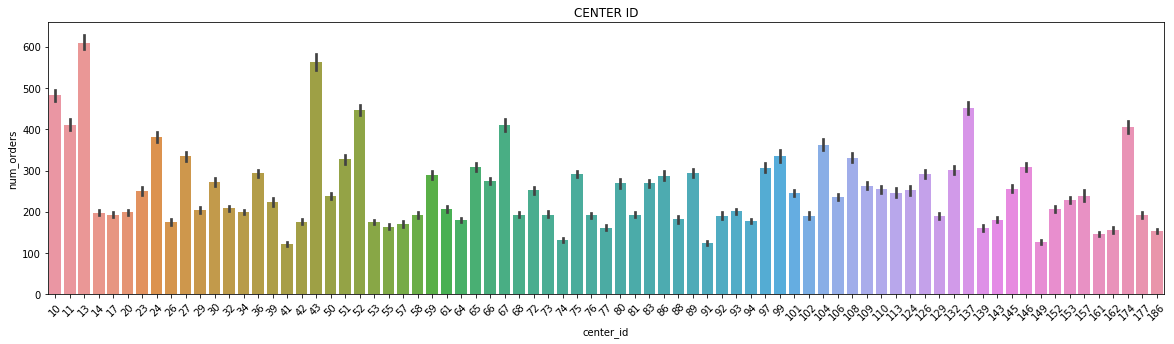




Amount of unique values for meal_id: 51


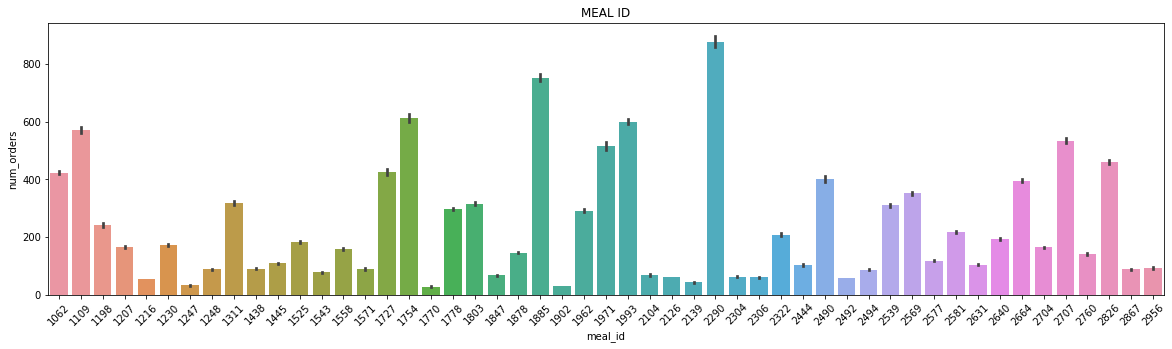




Amount of unique values for emailer_for_promotion: 2


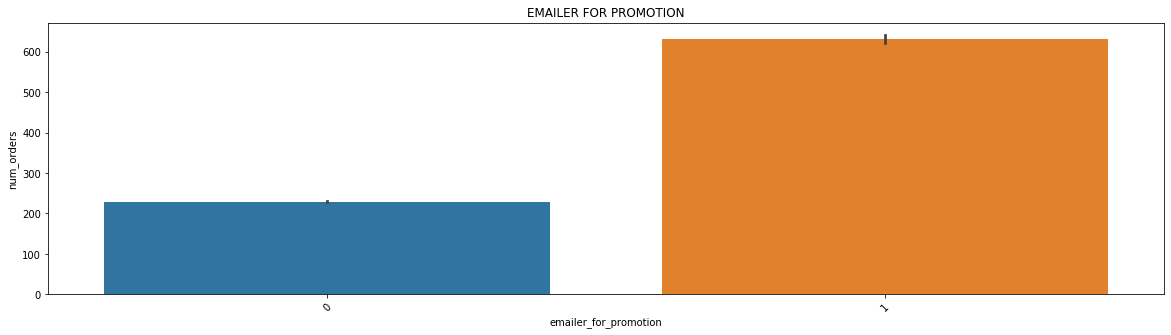




Amount of unique values for homepage_featured: 2


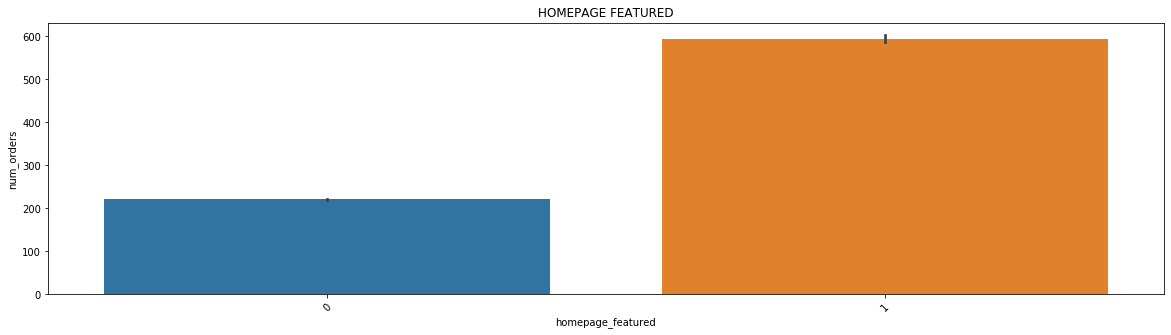




Amount of unique values for category: 14


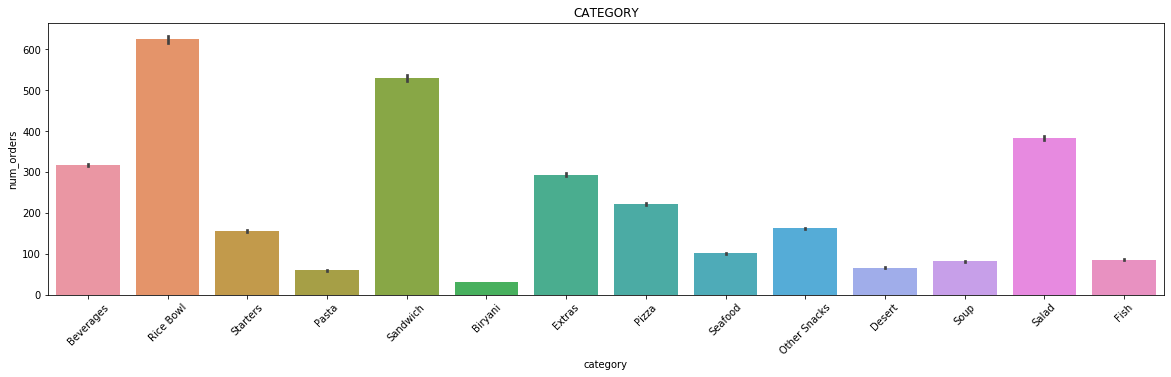




Amount of unique values for cuisine: 4


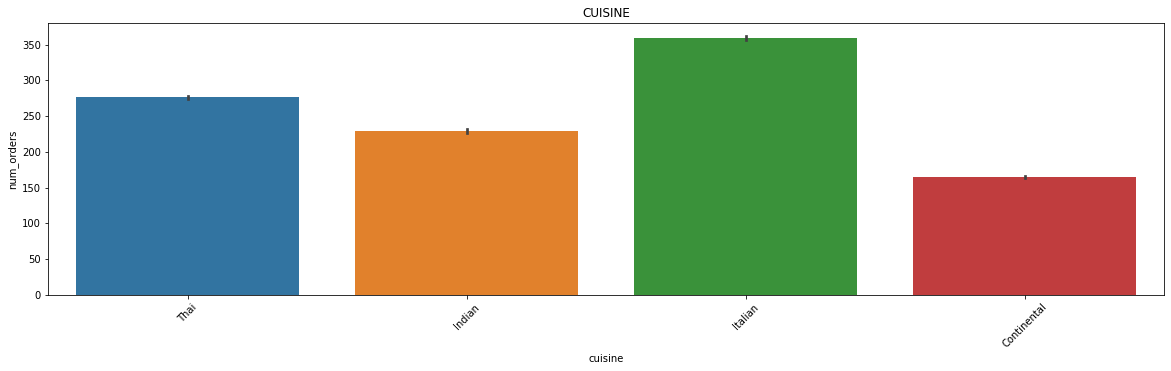




Amount of unique values for city_code: 51


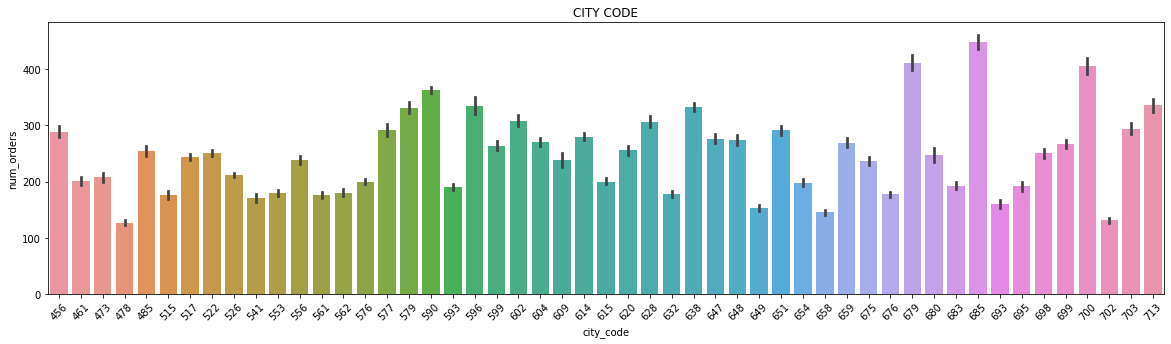




Amount of unique values for region_code: 8


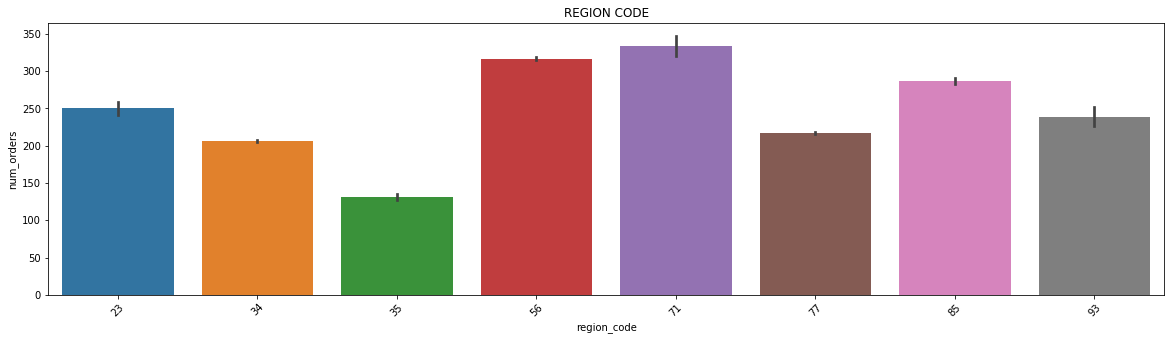




Amount of unique values for center_type: 3


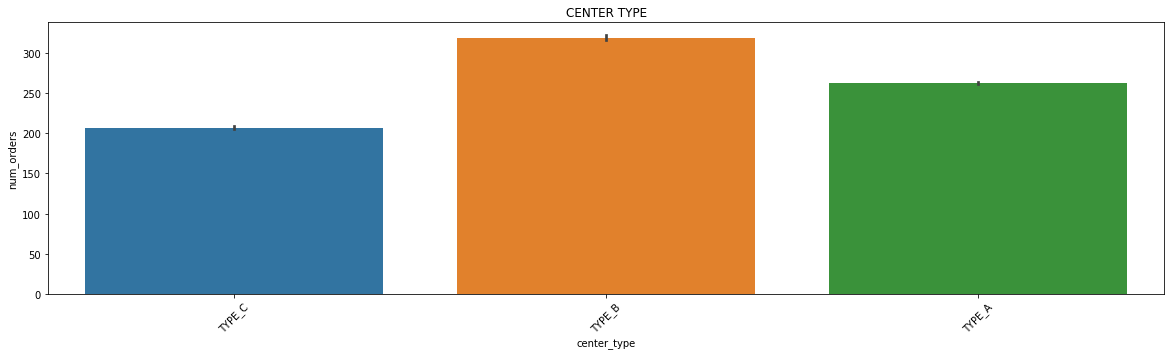




Amount of unique values for op_area: 30


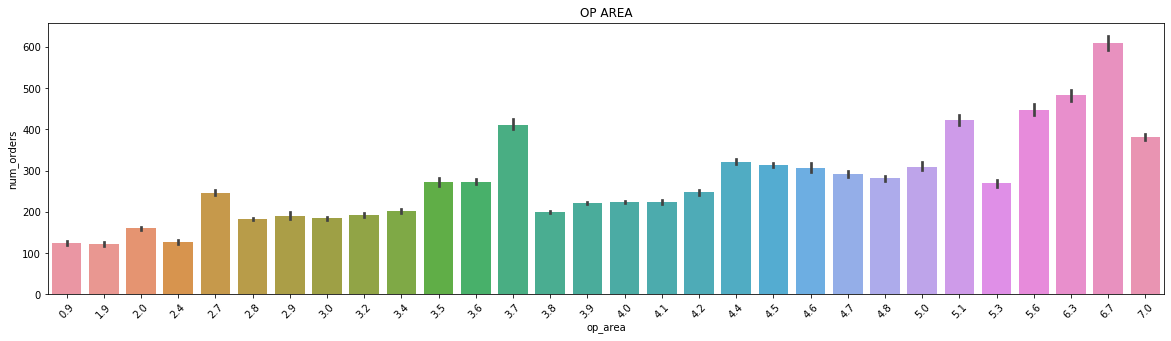

In [22]:
for cat in categorical_vars:
    print(f"Amount of unique values for {cat}: {train_df[cat].nunique()}")
    plt.figure(figsize=(20,5))
    sns.barplot(x=train_df[cat], y=train_df[target_name])
    plt.xticks(rotation=45)
    plt.title(cat.replace('_',' ').upper())
    plt.show()
    print('\n\n')